In [43]:
import pandas as pd
import numpy as np
import sys
import gc
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

#from keras.models import Sequential, model_from_json
#from keras.layers.core import Dense, Activation
#from keras.optimizers import Adagrad

import utils
from grid import RoadGrid

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
reload(utils)

<module 'utils' from 'utils.py'>

In [ ]:
def get_bs_count(data):
    bs_count = np.zeros(len(data))
    for i in xrange(1, 7):
        bs_count += (data['RNCID_%d'%i] != -999).astype(int).values
    return bs_count

In [71]:
tr_names = ['forward0', 'forward1', 'forward2', 'forward3', 'forwardbackward4', 'forwardbackward5', 'bu_1', 'bu_2', 'backward1', 'backward3']
#tr_names = ['forward0', 'forward1', 'forward2', 'forward3']
te_names = ['backward2']

tr_data = utils.get_4g_data(tr_names)
te_data = utils.get_4g_data(te_names)

eng_para = utils.get_4g_engpara()
tr_time, tr_feature, tr_label_ = utils.make_rf_dataset(tr_data, eng_para)
te_time, te_feature, te_label_ = utils.make_rf_dataset(te_data, eng_para)

tr_label = tr_data[['Longitude', 'Latitude']].values
te_label = te_data[['Longitude', 'Latitude']].values
#rg = RoadGrid(tr_label, 30)
#tr_label_ = np.array(rg.transform(tr_label, False))


In [146]:
error = []
header = ['RNCID', 'Test', 'Train', 'Time', 'mean', 'median', '80%', '90%']
exp_log = []
for record in te_data.groupby(['RNCID_1']):
    start = time.time()
    mask = (tr_data.RNCID_1.values == record[0])

    tr_feature_ = tr_feature[mask]
    tr_label_ = tr_label[mask]
    rg = RoadGrid(tr_label, 20)
    tr_label_ = np.array(rg.transform(tr_label_, False))
    
    te_time_, te_feature_, te_label_ = utils.make_rf_dataset(record[1], eng_para)
    te_feature_ = te_feature_.values
    te_label_ = te_label_.values
    
    
    '''
    iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1)
    iso_forest.fit(np.vstack((tr_feature_, te_feature_)))
    tr_anomaly_mask =  iso_forest.predict(tr_feature_) == -1
    tr_feature_ = tr_feature_[~tr_anomaly_mask]
    tr_label_ = tr_label_[~tr_anomaly_mask]
    
    te_anomaly_mask =  iso_forest.predict(te_feature_) == -1
    te_feature_ = te_feature_[~te_anomaly_mask]
    te_label_ = te_label_[~te_anomaly_mask]
    '''
    
    if len(te_feature_) == 0:
        continue
    
    est = RandomForestClassifier(
        n_jobs=-1,
        n_estimators = 50,
        max_features='sqrt',
#        bootstrap=True,
        criterion='entropy'
    ).fit(tr_feature_, tr_label_)
    
    te_pred = est.predict(te_feature_)
    te_pred = np.array([rg.grid_center[gid] for gid in te_pred])
    
    error_ = [utils.distance(pt1, pt2) for pt1, pt2 in zip(te_pred, te_label_)]
    error += error_
    content = [record[0], len(te_feature_), len(tr_feature_), time.time()-start, np.mean(error_), np.median(error_), np.percentile(error_, 80), np.percentile(error_, 90)]
    exp_log.append(content)
    del est
    gc.collect()
exp_log = pd.DataFrame(exp_log, columns=header)

In [145]:
iso_log = exp_log.copy()

In [148]:
norm_log = exp_log.copy()

In [144]:
utils.report(error, '%d\t%d\t%d' % (len(tr_data), len(te_data), tr_feature.shape[1]))

69210	4675	36	46.70	28.10	43.50	65.30	104.20


In [73]:
utils.report(error, '%d\t%d\t%d' % (len(tr_data), len(te_data), tr_feature.shape[1]))

69210	4675	36	47.33	27.40	42.90	65.30	107.80


In [143]:
exp_log.sort_values(by='mean', axis=0, ascending=False)

,RNCID,Test,Train,Time,mean,median,80%,90%
20,103257,63,4432,3.355821,120.996825,107.20,199.76,220.04
27,116056,16,26,1.303897,97.668750,37.55,49.40,304.75
3,99096,244,4214,3.485513,77.442623,31.40,113.34,237.87
1,99078,121,413,0.861402,72.879339,56.70,113.70,156.40
7,99112,335,3511,3.480330,67.819403,35.10,97.96,165.26
8,99121,147,2943,2.648799,60.621769,23.40,110.70,153.72
29,116773,114,1830,1.909984,55.821053,30.60,54.20,84.23
12,99165,615,2551,2.477687,52.213659,40.10,72.90,114.28
2,99084,41,1650,1.524808,44.214634,55.10,64.30,77.00
21,103330,350,4857,4.793871,42.118000,24.75,57.94,103.12


In [139]:
bad_rncid = exp_log.sort_values(by='mean', axis=0, ascending=False).RNCID.values

In [82]:
def print_by_rncid(rncid, tr_feature, tr_label, te_feature, te_label):
    tr_mask = (tr_feature.RNCID_1 == rncid).values
    te_mask = (te_feature.RNCID_1 == rncid).values
    tr_feature_ = tr_feature[tr_mask]
    tr_label_ = tr_label[tr_mask]
    te_feature_ = te_feature[te_mask]
    te_label_ = te_label[te_mask]
    
    plt.figure(figsize=(14,12))
    # plot background
    #plt.plot(tr_label[:,0], tr_label[:,1], 'b,')
    # plot train data
    plt.plot(tr_label_[:,0], tr_label_[:,1], 'y.')
    # plot test data
    plt.plot(te_label_[:,0], te_label_[:,1], 'ro')
    # plot train BS
    plt.plot(tr_feature_[u'经度1'].values, tr_feature_[u'纬度1'].values, 'go')
    # plot test BS
    plt.plot(te_feature_[u'经度1'].values, te_feature_[u'纬度1'].values, 'ko')

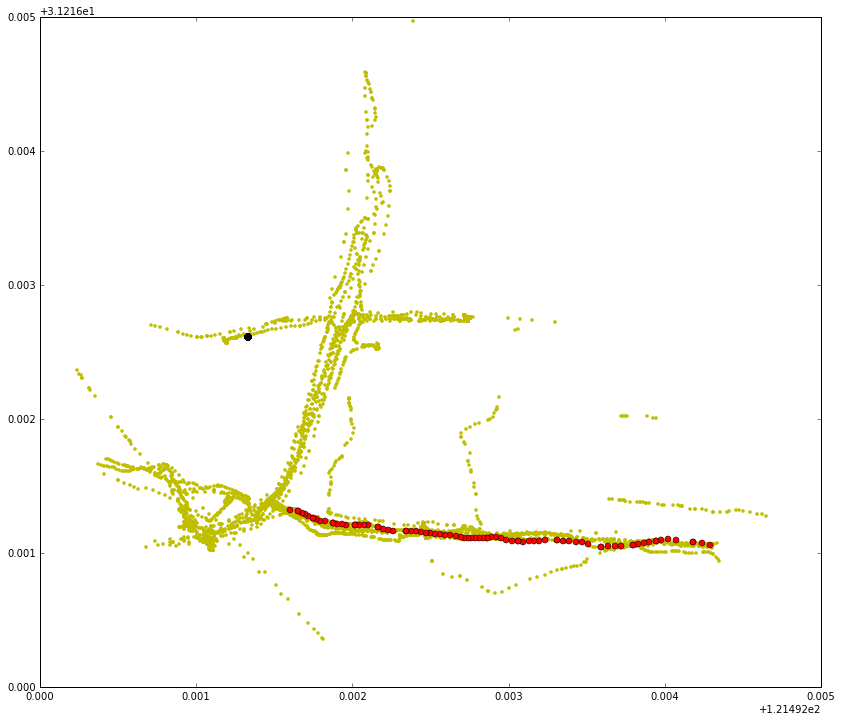

In [140]:

params = {
    'rncid': bad_rncid[0],
    'tr_feature': tr_feature,
    'tr_label': tr_label,
    'te_feature': te_feature,
    'te_label': te_label
}
print_by_rncid(**params)

In [34]:
tr_feature.columns

Index([ u'RNCID_1', u'CellID_1',   u'EcNo_1',   u'RSCP_1',  u'RNCID_2',
       u'CellID_2',   u'EcNo_2',   u'RSCP_2',  u'RNCID_3', u'CellID_3',
         u'EcNo_3',   u'RSCP_3',  u'RNCID_4', u'CellID_4',   u'EcNo_4',
         u'RSCP_4',  u'RNCID_5', u'CellID_5',   u'EcNo_5',   u'RSCP_5',
        u'RNCID_6', u'CellID_6',   u'EcNo_6',   u'RSCP_6',      u'经度1',
            u'纬度1',      u'经度6',      u'纬度6',      u'经度2',      u'纬度2',
            u'经度3',      u'纬度3',      u'经度4',      u'纬度4',      u'经度5',
            u'纬度5'],
      dtype='object')

In [127]:
def denoise_train(exp_log, idx):
    log = exp_log.sort_values(by='mean', axis=0, ascending=False).iloc[idx]
    rncid = int(log.RNCID)
    tr_mask = (tr_feature.RNCID_1 == rncid).values
    te_mask = (te_feature.RNCID_1 == rncid).values
    tr_feature_ = tr_feature[tr_mask]
    tr_label_ = tr_label[tr_mask]
    te_feature_ = te_feature[te_mask]
    te_label_ = te_label[te_mask]
    
    iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1)
    iso_forest.fit(tr_feature_)
    anomaly_mask =  iso_forest.predict(tr_feature_) == -1
    plt.plot(tr_label_[~anomaly_mask][:,0], tr_label_[~anomaly_mask][:,1], 'r.')
    plt.plot(tr_label_[anomaly_mask][:,0], tr_label_[anomaly_mask][:,1], 'yo')
    plt.plot(te_label_[:,0], te_label_[:,1], 'g.')

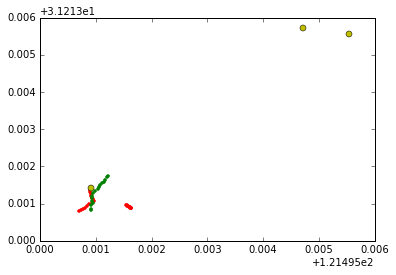

In [128]:
denoise_train(exp_log, 0)

In [56]:
tr_bs_count = get_bs_count(tr_feature_)
te_bs_count = get_bs_count(te_feature_)

In [150]:
merge_log = pd.merge(left=norm_log, right=iso_log, left_on=['RNCID'], right_on=['RNCID'])

In [161]:
sum(((merge_log['90%_x']-merge_log['90%_y']) > 0).astype(int))

14

In [157]:
len(merge_log)

31

In [159]:
merge_log

,RNCID,Test_x,Train_x,Time_x,mean_x,median_x,80%_x,90%_x,Test_y,Train_y,Time_y,mean_y,median_y,80%_y,90%_y
0,99077,23,202,0.645560,29.373913,16.10,48.10,61.84,23,179,0.830103,26.756522,22.40,42.50,53.54
1,99078,123,471,0.630112,70.195935,58.10,103.70,132.50,121,413,0.861402,72.879339,56.70,113.70,156.40
2,99084,74,1805,0.942388,33.883784,23.95,61.70,65.00,41,1650,1.524808,44.214634,55.10,64.30,77.00
3,99096,282,4672,1.515338,70.414894,27.80,112.60,237.32,244,4214,3.485513,77.442623,31.40,113.34,237.87
4,99097,31,453,0.682896,28.403226,19.00,23.30,28.00,18,417,0.893048,20.900000,21.45,23.30,24.71
5,99099,79,950,0.704777,36.529114,15.60,52.94,95.12,67,859,1.049380,35.808955,16.10,49.54,87.18
6,99110,38,805,0.649109,39.892105,13.65,35.18,141.62,33,725,1.199459,25.821212,11.70,31.96,65.24
7,99112,369,3905,1.713663,78.137669,43.40,118.56,188.62,335,3511,3.480330,67.819403,35.10,97.96,165.26
8,99121,168,3266,1.433450,53.287500,23.45,104.76,148.63,147,2943,2.648799,60.621769,23.40,110.70,153.72
9,99127,671,3063,1.139669,38.859016,26.70,56.30,87.50,636,2724,2.678772,41.351415,26.40,59.60,95.00
